In [ ]:
import requests
import openpyxl
import schedule
import time
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter


In [2]:
API_KEY = {'X-API-key': 'PGZ96MHQ'}
s = requests.Session()
s.headers.update(API_KEY)
resp = s.get('http://localhost:9999/v1/case')
resp

<Response [200]>

In [3]:
r2 = s.get('http://localhost:9999/v1/securities/book', params = {'ticker': 'ORNG'}).json() 
# get the info book for this ticker

In [4]:
def send_order(sym, side, price, size):
    resp = s.post('http://localhost:9999/v1//orders', params = {'ticker': sym, 'type': 'LIMIT', 'action': side, 'quantity': size, 'price': price})
    if resp.ok: 
        print('SENT:', side, sym, size, '@', price)
        print('Order ID:', resp.json()['order_id'])
    else:
        print('failed to send order', side, sym, size, '@', price, ':', resp.text)

send_order('ORNG', 'BUY', 50.00, 10)

SENT: BUY ORNG 10 @ 50.0
Order ID: 2842


In [77]:
file_path = 'data.xlsx'

In [136]:
s.get('http://localhost:9999/v1//news').json()

[{'news_id': 2,
  'period': 1,
  'tick': 359,
  'ticker': '',
  'headline': 'Your personal harvest of oranges is 72.',
  'body': ''},
 {'news_id': 1,
  'period': 1,
  'tick': 179,
  'ticker': '',
  'headline': 'Your personal harvest of apples is 81.',
  'body': ''}]

In [ ]:
def get_counts():
    counts = pd.DataFrame(s.get('http://localhost:9999/v1//news').json())['headline'].apply(lambda x: int("".join(c for c in x if c.isdigit())))[::-1].tolist()

    wb = openpyxl.load_workbook(filename=file_path)
    sheet = wb.active

    sheet.append(counts)

    wb.save(filename=file_path)

get_counts()

In [ ]:
# Schedule the function to run every 15 minutes
schedule.every(15).minutes.do(get_counts)

# Infinite loop to keep the script running and check the schedule
while True:
    schedule.run_pending()
    time.sleep(1) # Sleep for a short time to avoid high CPU usage

TypeError: the first argument must be callable

In [138]:
def all_data_graph(sym):
    frt = ''
    if sym == 'APPL':
        frt = 'Apples'
    elif sym == 'ORNG':
        frt = 'Oranges'
    data = pd.read_excel('all_groups_counts.xlsx')
    data_count = pd.DataFrame.from_dict(Counter(data[frt]), orient='index', columns=['count']).reset_index()
    plt.scatter(data_count['index'], data_count.reset_index()['count'])

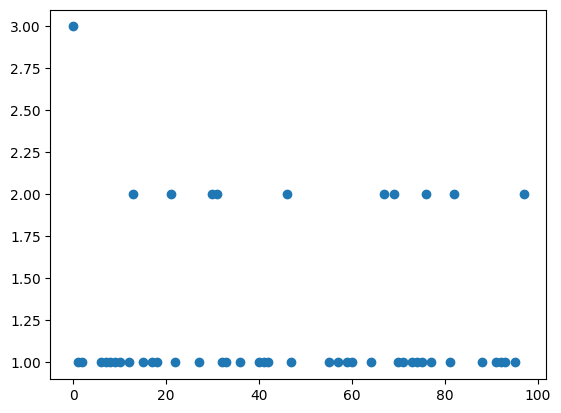

In [139]:
all_data_graph('APPL')

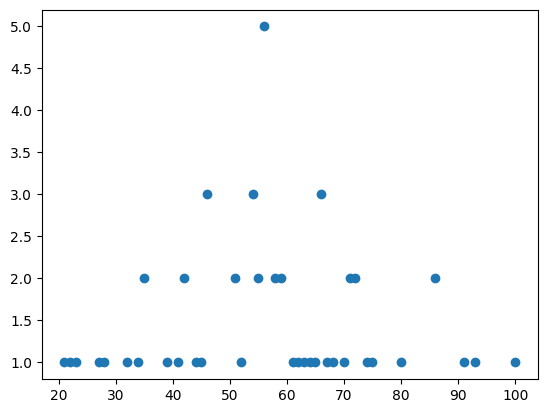

In [140]:
all_data_graph('ORNG')

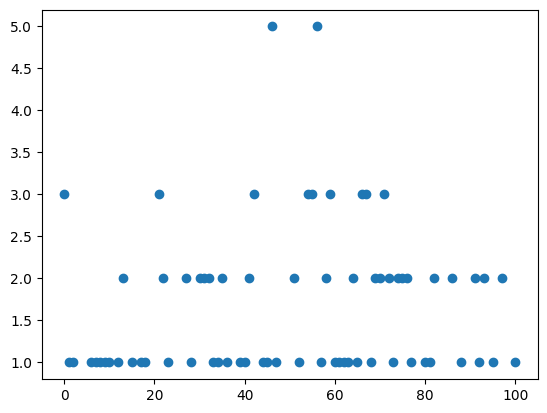

In [144]:
data = pd.read_excel('all_groups_counts.xlsx')
data_count = pd.DataFrame.from_dict(Counter(pd.concat([data['Apples'],data['Oranges']])), orient='index', columns=['count']).reset_index()
plt.scatter(data_count['index'], data_count.reset_index()['count'])

In [123]:
def graph_counts(sym):
    data = pd.read_excel(file_path)
    frt = ''
    frt5 = ''
    frt10 = ''
    if sym == 'APPL':
        frt = 'Apples'
        frt5 = '5 Random Apple'
        frt10 = 'Total Apple'
    elif sym == 'ORNG':
        frt = 'Oranges'
        frt5 = '5 Random Orange'
        frt10 = 'Total Orange'
    frt_df = pd.concat([data[frt], data[frt5]/5, data[frt10]/10]).reset_index(drop=True)
    frt_count = pd.DataFrame.from_dict(Counter(frt_df), orient='index', columns=['count']).reset_index()
    plt.scatter(frt_count['index'], frt_count.reset_index()['count'])

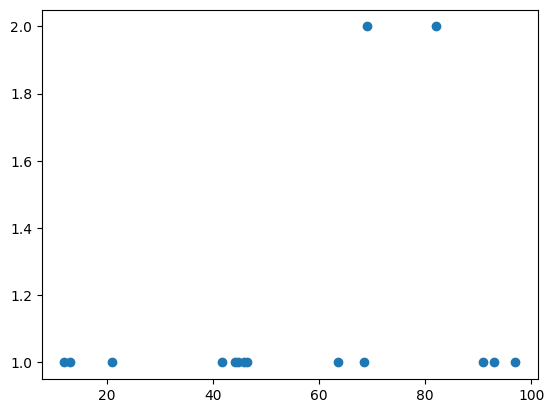

In [124]:
graph_counts('APPL')

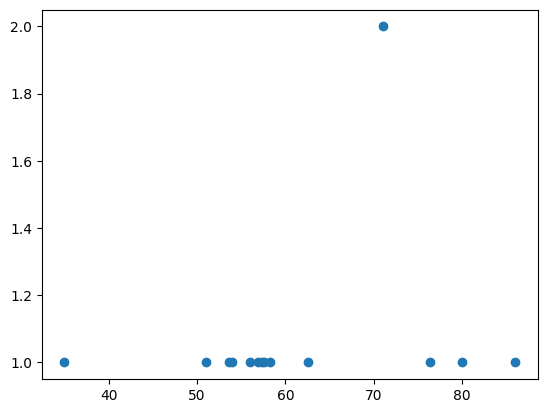

In [125]:
graph_counts('ORNG')

In [11]:
tas = s.get('http://localhost:9999/v1/securities/tas', params={'ticker':'ORNG'}).json()

In [18]:
tas_df = pd.DataFrame.from_dict(tas)
tas_df

,id,period,tick,price,quantity
0,4084,1,283,1100.0,37.0
1,4083,1,283,1100.0,155.0
2,4082,1,283,1100.0,76.0
3,4049,1,281,1100.0,37.0
4,4048,1,281,1100.0,106.0
...,...,...,...,...,...
554,50,1,5,1100.0,16.0
555,38,1,4,1100.0,106.0
556,37,1,4,1100.0,159.0
557,12,1,2,1100.0,20.0


In [ ]:
tas_df['price']

0      1100.0
1      1100.0
2      1100.0
3      1100.0
4      1100.0
        ...  
554    1100.0
555    1100.0
556    1100.0
557    1100.0
558    1100.0
Name: price, Length: 559, dtype: float64

In [21]:
Counter(tas_df['price'])

Counter({1100.0: 344, -100.0: 204, 671.64: 4, 667.68: 3, 670.06: 2, 666.43: 2})

In [22]:
history = s.get('http://localhost:9999/v1/securities/history', params={'ticker':'ORNG'}).json()

In [27]:
pd.DataFrame(history)

,tick,open,high,low,close
0,804,1100.0,1100.0,1100.0,1100.0
1,803,1100.0,1100.0,1100.0,1100.0
2,802,1100.0,1100.0,1100.0,1100.0
3,801,1100.0,1100.0,1100.0,1100.0
4,800,1100.0,1100.0,1100.0,1100.0
...,...,...,...,...,...
799,5,1100.0,1100.0,1100.0,1100.0
800,4,1100.0,1100.0,1100.0,1100.0
801,3,1100.0,1100.0,1100.0,1100.0
802,2,0.0,1100.0,0.0,1100.0
